## Medical insurance data set
* https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset
    * 1400 data points

## Results
* DNN: R² of 0.83
* RandomForest: R² of 0.87
* LinearRegression: bad idea, non-linear data R² of 0.78
* Same with Ridge Regressor

### Next steps
* Data augmentation
* cross validation
* privacy attacks
* differential privacy


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
# Import the DNN functions
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow_addons.metrics import RSquare
import keras_tuner

validation_split_size = 0.2

In [31]:
# Load and preprocess the data
dataset = pd.read_csv('data/insurance.csv')
# Make non numerical features (sex, region, smoker) to categorical features
dataset['sex'] = dataset['sex'].astype('category').cat.codes
dataset['region'] = dataset['region'].astype('category').cat.codes
dataset['smoker'] = dataset['smoker'].astype('category').cat.codes
# One hot encoding
dataset[['region0', 'region1', 'region2', 'region3']] = pd.get_dummies(dataset['region'])
# Scale data into [0, 1]
scaler = MinMaxScaler()
dataset[['age', 'bmi', 'children']] = scaler.fit_transform(dataset[['age', 'bmi', 'children']])
dataset

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0,0.321227,0.0,1,3,16884.92400,0,0,0,1
1,0.000000,1,0.479150,0.2,0,2,1725.55230,0,0,1,0
2,0.217391,1,0.458434,0.6,0,2,4449.46200,0,0,1,0
3,0.326087,1,0.181464,0.0,0,1,21984.47061,0,1,0,0
4,0.304348,1,0.347592,0.0,0,1,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,1,0.403820,0.6,0,1,10600.54830,0,1,0,0
1334,0.000000,0,0.429379,0.0,0,0,2205.98080,1,0,0,0
1335,0.000000,0,0.562012,0.0,0,2,1629.83350,0,0,1,0
1336,0.065217,0,0.264730,0.0,0,3,2007.94500,0,0,0,1


In [30]:
# Functions for easy data handling and feature definition
training_features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region0', 'region1', 'region2', 'region3']
target_variable = 'charges'
def get_x(d):
    """Return the before defined training_features from the given data.

    :param d: The data to filter the features from
    :type d: pandas.DataFrame
    :return: The data of the training_features
    :rtype: pandas.DataFrame
    """
    return d[training_features]

def get_y(d):
    """Return the before defined target_variable from the given data.

    :param d: The data to filter the features from
    :type d: pandas.DataFrame
    :return: The data of the training_features
    :rtype: pandas.DataFrame
    """
    return d[[target_variable]]

In [19]:
# Divide data into train and test data
X_train, X_test, y_train, y_test = train_test_split(dataset[training_features], dataset[[target_variable]], test_size=0.2, random_state=42,
                                                    shuffle=True)

In [54]:
def plot_loss(history, y_min=None, y_max=None, save_path=None):
    """Plot the training history and save the figure.

    :param history: The history object including the metrics to plot
    :type history: keras.callbacks.History
    :param y_min: The lover limit of the plot
    :type y_min: float, optional
    :param y_max: The upper limit of the plot
    :type y_max: float, optional
    :param save_path: The path to save the plot, if None, it will not be saved
    :type save_path: str, optional
    """
    plt.plot(history.history['r_square'], label='train R^2')
    plt.plot(history.history['val_r_square'], label='test R^2')
    if y_min is not None and y_max is not None:
        plt.ylim([y_min, y_max])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path)

# DNN

In [51]:
# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

In [52]:
# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    epochs=100)

Epoch 1/100
27/27 [==============================] - 1s 18ms/step - loss: 13518.7490 - mae: 13518.7490 - mean_squared_error: 325473792.0000 - r_square: -1.2806 - val_loss: 12655.3281 - val_mae: 12655.3281 - val_mean_squared_error: 310362912.0000 - val_r_square: -1.0663
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 13518.2314 - mae: 13518.2314 - mean_squared_error: 325459520.0000 - r_square: -1.2805 - val_loss: 12654.8145 - val_mae: 12654.8145 - val_mean_squared_error: 310349440.0000 - val_r_square: -1.0662
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 13517.6768 - mae: 13517.6768 - mean_squared_error: 325444288.0000 - r_square: -1.2804 - val_loss: 12654.1445 - val_mae: 12654.1445 - val_mean_squared_error: 310331776.0000 - val_r_square: -1.0661
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 13516.7617 - mae: 13516.7617 - mean_squared_error: 325418752.0000 - r_square: -1.2802 - val_loss: 12652.8037 - val_mae:

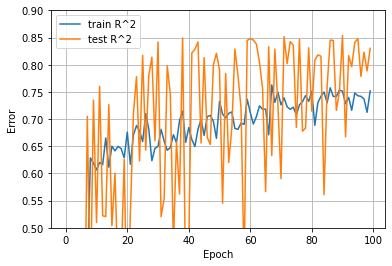

In [55]:
plot_loss(dnn_history, y_min=0.5, y_max=0.9, save_path="rsquared_init_params.jpg")

In [26]:
# Test to predict one sample, features are: 'age', 'sex', 'bmi', 'children', 'smoker', 'region'
# The region feature is one hot encoded over four different regions so the last four features blong to region
dnn_model.predict([[0.9, 0, 0, 0.1, 0, 0,0,0,1]])

1/1 [==============================] - 0s 216ms/step


array([[12988.019]], dtype=float32)

#### keras tune: DNN Hyper search

In [33]:
def build_model(hp):
    """Build and compile model for hyperparameter search

    :param hp: Hyperparameter object to define model parameters
    :type hp: keras_tuner.HyperParameters
    :return: The build and compiled model
    :rtype: keras.Model
    """
    model = keras.Sequential()
    model.add(Dense(
        # Define the hyperparameters.
        units=hp.Int("units_0", min_value=8, max_value=64, step=8),
        activation="relu",
    ))
    if hp.Boolean("dropout"):
        model.add(Dropout(
            rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.3, step=0.05)
        ))
    model.add(Dense(
        # Define the hyperparameter.
        units=hp.Int("units_1", min_value=2, max_value=14, step=4), activation="relu",
    ))
    model.add(Dense(1))
    model.compile(
        optimizer="sgd",
        loss="mae",
        metrics=["mae", 'mean_squared_error', RSquare()],
    )
    return model

In [41]:
# Prepare hyperparameter search
build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_mae",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="keras_tune_results",
    project_name="insurance-dnn-tuner",
)


In [42]:
# Search best parameters
tuner.search(X_train, y_train, epochs=100, validation_split=validation_split_size)

Trial 3 Complete [00h 00m 30s]
val_mae: 2194.21728515625

Best val_mae So Far: 2088.236572265625
Total elapsed time: 00h 01m 30s
INFO:tensorflow:Oracle triggered exit


In [45]:
# Get best found parameters and build such model
best_hps = tuner.get_best_hyperparameters(5)
best_model = build_model(best_hps[0])
best_model.build(input_shape=(None,9))
#best_model.build(input_shape=(None,9))
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 56)                560       
                                                                 
 dense_7 (Dense)             (None, 10)                570       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = best_model.fit(
    X_train,
    y_train,
    #batch_size=16,
    shuffle=True,
validation_split=validation_split_size,
epochs=100)

Epoch 1/100
27/27 [==============================] - 1s 18ms/step - loss: 13518.2959 - mae: 13518.2959 - mean_squared_error: 325460576.0000 - r_square: -1.2805 - val_loss: 12654.7363 - val_mae: 12654.7363 - val_mean_squared_error: 310346880.0000 - val_r_square: -1.0662
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 13517.1953 - mae: 13517.1953 - mean_squared_error: 325429216.0000 - r_square: -1.2802 - val_loss: 12653.0381 - val_mae: 12653.0381 - val_mean_squared_error: 310303328.0000 - val_r_square: -1.0659
Epoch 3/100
27/27 [==============================] - 0s 4ms/step - loss: 13513.4775 - mae: 13513.4775 - mean_squared_error: 325325952.0000 - r_square: -1.2795 - val_loss: 12644.9209 - val_mae: 12644.9209 - val_mean_squared_error: 310089216.0000 - val_r_square: -1.0644
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 13462.9883 - mae: 13462.9883 - mean_squared_error: 323896032.0000 - r_square: -1.2695 - val_loss: 12382.0352 - val_mae:

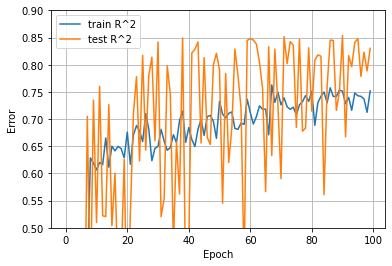

In [59]:
# Comparison with the above trained model (before hyperparameter search)
plot_loss(dnn_history, y_min=0.5, y_max=0.9)

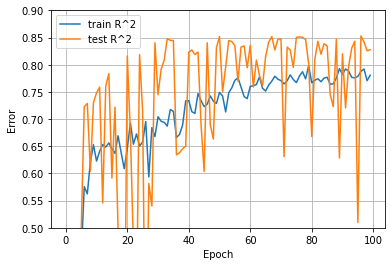

In [60]:
plot_loss(history, y_min=0.5, y_max=0.9, save_path="rsquared_hyperparams.jpg")

In [63]:
# Evaluate the model with the test data
result = best_model.evaluate(X_test, y_test)
print(str(result))

9/9 [==============================] - 0s 2ms/step - loss: 2923.1877 - mae: 2923.1877 - mean_squared_error: 28920794.0000 - r_square: 0.8137
[2923.187744140625, 2923.187744140625, 28920794.0, 0.8137131929397583]


# Random Forest

In [66]:
def cross_validate(model, X_train, y_train, cross_val_test_set_size):
    """Cross validate a model and return mean and standard deviation for given data

    :param model: model to test
    :type model: keras.Model
    :param X_train: test set (X, features)
    :type X_train: pandas.DataFrame
    :param y_train: test set (y, labels)
    :type y_train: pandas.DataFrame
    :param cross_val_test_set_size: relative size of validation set
    :type cross_val_test_set_size: float
    :return: mean and standard deviation for test scores
    :rtype: float, float
    """
    cv = ShuffleSplit(n_splits=5, test_size=cross_val_test_set_size, random_state=0)
    scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=cv)
    return scores.mean(), scores.std()

In [69]:
# Cross validation of Random Forest model
clf = RandomForestRegressor(max_depth=4, random_state=0)
mean, std = cross_validate(clf, X_train, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
clf.fit(X_train, y_train.values.ravel())

RANDOM FOREST: 0.84147 mean accuracy with a standard deviation of 0.01782


RandomForestRegressor(max_depth=4, random_state=0)

In [70]:
# Calculate the r² score for the test data
clf.score(X_test, y_test.values.ravel())

0.8714346169733819

In [71]:
# A test prediction
clf.predict([[0.9, 0, 0, 0.1, 0, 0,0,0,1]])

/informatik1/students/home/0zadim/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([14183.52296664])

### Hyperparemeter tuning

In [73]:
# Do the hyperparameter tuning for the Random Forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [3,4,5,6]
max_features = [0.5,0.6,0.7,0.8,0.9,0.95,1.0]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 300 candidates, totalling 900 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=300,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9, 0.95, 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [74]:
# Print best results and create forest with these values
print(f'BEST PARAMS: {rf_random.best_params_}')
rand_forest_improved = RandomForestRegressor(**rf_random.best_params_)

BEST PARAMS: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 5, 'bootstrap': True}


In [75]:
# Tran the "best" model
mean, std = cross_validate(rand_forest_improved, X_train, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
rand_forest_improved.fit(X_train, y_train.values.ravel())
rand_forest_improved.score(X_test, y_test.values.ravel())

RANDOM FOREST: 0.84193 mean accuracy with a standard deviation of 0.01986


0.8800749858766648

In [78]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [4,5,6],
    'max_features': [0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [3,4,5,6,7,8,9,10],
    'n_estimators': [900, 950, 1000, 1050, 1100, 1150]
}# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 3, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train.values.ravel())
grid_search.best_params_

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


{'bootstrap': True,
 'max_depth': 4,
 'max_features': 0.8,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 1050}

In [90]:
# Get the best parameters using grid search
print(f'BEST PARAMS: {grid_search.best_params_}')
rand_forest_improved_grid = RandomForestRegressor(**grid_search.best_params_)

BEST PARAMS: {'bootstrap': True, 'max_depth': 4, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 1050}


In [94]:
# Train the model with the best parameters found with grind search
mean, std = cross_validate(rand_forest_improved_grid, X_train, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
rand_forest_improved_grid.fit(X_train, y_train.values.ravel())
rand_forest_improved_grid.score(X_test, y_test.values.ravel())

RANDOM FOREST: 0.84297 mean accuracy with a standard deviation of 0.01966


0.87710858459907

## Random Forest without region attribute (test scenario)

In [83]:
X_train

,age,sex,bmi,children,smoker,region0,region1,region2,region3
560,0.608696,0,0.107345,0.4,0,0,1,0,0
1285,0.630435,0,0.224913,0.0,0,1,0,0,0
1142,0.739130,0,0.239440,0.0,0,0,0,1,0
969,0.456522,0,0.493947,1.0,0,0,0,1,0
486,0.782609,0,0.148238,0.6,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1095,0.000000,0,0.414044,0.8,0,1,0,0,0
1130,0.456522,0,0.212806,1.0,0,0,0,1,0
1294,0.869565,1,0.247915,0.0,0,1,0,0,0
860,0.413043,0,0.851224,0.4,1,0,0,0,1


In [84]:
# Create data without the region attribute
X_train_no_region = X_train.copy()
X_train_no_region = X_train_no_region.drop(columns=["region0", "region1", "region2", "region3"])

X_test_no_region = X_test.copy()
X_test_no_region = X_test_no_region.drop(columns=["region0", "region1", "region2", "region3"])

In [95]:
# Create a model with reliable parameters and do cross validation without the region data
rf_no_region = RandomForestRegressor(bootstrap=True, max_depth=4, max_features=0.8, min_samples_leaf=5, min_samples_split=9, n_estimators=1050)

mean, std = cross_validate(rf_no_region, X_train_no_region, y_train, validation_split_size)
print("RANDOM FOREST: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
rf_no_region.fit(X_train_no_region, y_train.values.ravel())
rf_no_region.score(X_test_no_region, y_test.values.ravel())

RANDOM FOREST: 0.84320 mean accuracy with a standard deviation of 0.01920


0.8776530613504745

In [96]:
# As a test the results with region data
rand_forest_improved_grid.score(X_test, y_test.values.ravel())

0.87710858459907

## Linear Regression

In [87]:
from sklearn.linear_model import LinearRegression

clf_lr = LinearRegression()
mean, std = cross_validate(clf_lr, X_train, y_train, validation_split_size)
print("LINEAR REGRESSION: %0.5f mean accuracy with a standard deviation of %0.5f" % (mean, std))
clf_lr.fit(X_train, y_train.values.ravel())

LINEAR REGRESSION: 0.72334 mean accuracy with a standard deviation of 0.02784


LinearRegression()

In [88]:
clf_lr.score(X_test, y_test.values.ravel())

0.7835929767120722